## Simple graph example

In [ ]:
import numpy as np

# simple computational graph - numpy
N, D = 3, 4
np.random.seed(0)
x = np.random.randn(N, D)
y = np.random.randn(N, D)
z = np.random.randn(N, D)

a = x * y  # shape (N, D)
b = a + z  # shape (N, D)
c = np.sum(b)

grad_c = 1.0
grad_b = grad_c * np.ones((N,D))
grad_a = grad_b.copy()
grad_z = grad_b.copy()
grad_x = grad_a * y
grad_y = grad_a * x

print(c)
print(grad_x)
print(grad_y)
print(grad_z)

In [1]:
#TENSORFLOW 1.X
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() # to use former syntax of
                         # tensorflow 1.X, eg 1.14

# simple computational graph with tensorflow 
N, D = 3, 4
np.random.seed(0)
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, D))
z = tf.placeholder(tf.float32, shape=(N, D))

a = x * y
b = a + z
c = tf.reduce_sum(b)

grad_x, grad_y, grad_z = tf.gradients(c, [x, y, z])

with tf.Session() as sess:
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D),
        z: np.random.randn(N, D)
    }
    out = sess.run([c, grad_x, grad_y, grad_z], 
                   feed_dict=values)
    c_val, grad_x_val, grad_y_val, grad_z_val = out

    print(c_val)
    print(grad_x_val)
    print(grad_y_val)

Instructions for updating:
non-resource variables are not supported in the long term
6.7170086
[[ 0.7610377   0.12167501  0.44386324  0.33367434]
 [ 1.4940791  -0.20515826  0.3130677  -0.85409576]
 [-2.5529897   0.6536186   0.8644362  -0.742165  ]]
[[ 1.7640524   0.4001572   0.978738    2.2408931 ]
 [ 1.867558   -0.9772779   0.95008844 -0.1513572 ]
 [-0.10321885  0.41059852  0.14404356  1.4542735 ]]


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() # to use former syntax of
                         # tensorflow 1.X, eg 1.14

# simple computational graph - tensorflow on gpu
N, D = 3, 4
with tf.device('/GPU:0'): # '/CPU:0' for cpu exec 
    x = tf.placeholder(tf.float32, shape=(N, D))
    y = tf.placeholder(tf.float32, shape=(N, D))
    z = tf.placeholder(tf.float32, shape=(N, D))
    a = x * y
    b = a + z
    c = tf.reduce_sum(b)

    grad_x, grad_y, grad_z = tf.gradients(c, [x, y, z])

with tf.Session() as sess:
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D),
        z: np.random.randn(N, D)
    }
    out = sess.run([c, grad_x, grad_y, grad_z],
                   feed_dict=values)
    c_val, grad_x_val, grad_y_val, grad_z_val = out

    print(c_val)
    print(grad_x_val)
    print(grad_y_val)

-3.5299413
[[-1.6138978  -0.21274029 -0.89546657  0.3869025 ]
 [-0.51080513 -1.1806322  -0.02818223  0.42833188]
 [ 0.06651722  0.3024719  -0.6343221  -0.36274117]]
[[ 1.2302907   1.2023798  -0.3873268  -0.30230275]
 [-1.048553   -1.420018   -1.7062702   1.9507754 ]
 [-0.5096522  -0.4380743  -1.2527953   0.7774904 ]]


In [ ]:
# Just as example to show how it looks in PyTorch 
# You can skip this cell if you don't want to install PyTorch
import torch
from torch.autograd import Variable

# simple computational graph - torch on gpu
N, D = 3, 4

x = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)
y = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)
z = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)

a = x * y
b = a + z
c = torch.sum(b)

c.backward()

print(x.grad.data)
print(y.grad.data)
print(z.grad.data)

## A more complex example of graph

### Utility function - plot history

In [3]:
import matplotlib.pyplot as plt

def plot_history(epoch_vector, losses_list, name_list, y_label):
    # plt.figure(figsize=(12,8))
    for i, losses in enumerate(losses_list):
        plt.plot(epoch_vector, losses, label=name_list[i])
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

### Step 0: get some data

In [4]:
# First get some data and prepare it
mnist = tf.keras.datasets.mnist
(x_train, y_train_vec),(x_test, y_test_vec) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train_vec, 10, dtype='float64')
y_test = tf.keras.utils.to_categorical(y_test_vec, 10, dtype='float64')
N = x_train.shape[0]  # number of samples
D = x_train.shape[1]  # dimension of input sample
n_classes = y_train.shape[1] # output dim
print('MNIST data set ready. N={}, D={}, n_classes={}'.format(N,D,n_classes))

MNIST data set ready. N=60000, D=784, n_classes=10


### Step 1
This graph is actually creating the necessary nodes to:
1. Do the forward pass (line 13)
2. Compute the MSE loss (lines 14 and 15)
3. Compute the gradients of the loss w.r.t. the weights (line 17)

In line 23, we init the weights (outside of the graph, using numpy). In line 25 we use the graph, passing the whole train set in the feed_dict (inputs, targets, weight) and getting out of the graph the loss and the gradient values.

In [8]:
# TensorFlow 1.x - a more complex example
# step 1 - forward pass on single layer ANN with ReLu
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() # to use former syntax of
                         # tensorflow 1.X, eg 1.14

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))
w1 = tf.placeholder(tf.float32, shape=(D, n_classes))

y_pred = tf.maximum(tf.matmul(x, w1), 0) # ReLU on logit
diff = y_pred - y
loss = tf.reduce_mean(tf.pow(diff, 2))

grad_w1 = tf.gradients(loss, [w1])

with tf.Session() as sess:
    values = {
        x: x_train,
        y: y_train,
        w1: np.random.randn(D, n_classes)
    }
    out = sess.run([loss, grad_w1], feed_dict=values)
    loss_val, grad_w1_val = out

print(loss_val, np.array(grad_w1_val).shape)

113.47453 (1, 784, 10)


epoch 0 45.029823
epoch 1 41.191513
epoch 2 37.8147
epoch 3 34.834732
epoch 4 32.196495
epoch 5 29.853277
epoch 6 27.765287
epoch 7 25.898695
epoch 8 24.22463
epoch 9 22.71827
epoch 10 21.358467
epoch 11 20.12718
epoch 12 19.008913
epoch 13 17.990356
epoch 14 17.059958
epoch 15 16.20778
epoch 16 15.425225
epoch 17 14.70484
epoch 18 14.040087
epoch 19 13.425289


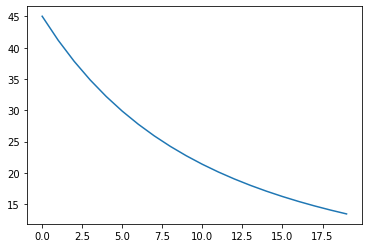

In [11]:
# TensorFlow 1.x - a more complex example
# step 2 - training but weights are passing from gpu to cpu
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as pl

tf.disable_v2_behavior() # to use former syntax of
                         # tensorflow 1.X, eg 1.14

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))
w1 = tf.placeholder(tf.float32, shape=(D, n_classes))

y_pred = tf.maximum(tf.matmul(x, w1), 0) # ReLU on logit
diff = y_pred - y
loss = tf.reduce_mean(tf.pow(diff, 2))

grad_w1 = tf.gradients(loss, [w1])[0] # returns a list of
                                      # sums of gradients

with tf.Session() as sess:
    values = {
        x: x_train,
        y: y_train,
        w1: np.random.randn(D, n_classes)
    }
    alpha = 1e-2
    J = []
    for epoch in range(20):
        out = sess.run([loss, grad_w1], feed_dict=values)
        loss_val, grad_w1_val = out
        values[w1] -= alpha * grad_w1_val
        J.append(loss_val)
        print("epoch", epoch, loss_val)
    pl.plot(J)

epoch 0 [12.368187]
epoch 1 [12.368187]
epoch 2 [12.368187]
epoch 3 [12.368187]
epoch 4 [12.368187]
epoch 5 [12.368187]
epoch 6 [12.368187]
epoch 7 [12.368187]
epoch 8 [12.368187]
epoch 9 [12.368187]
epoch 10 [12.368187]
epoch 11 [12.368187]
epoch 12 [12.368187]
epoch 13 [12.368187]
epoch 14 [12.368187]
epoch 15 [12.368187]
epoch 16 [12.368187]
epoch 17 [12.368187]
epoch 18 [12.368187]
epoch 19 [12.368187]


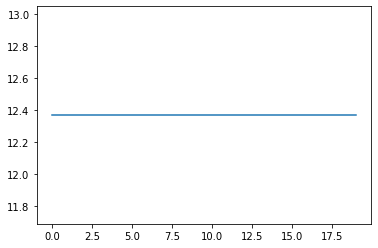

In [12]:
# TensorFlow 1.x - a more complex example
# step 3 - change weights from placehoders to variables
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as pl

tf.disable_v2_behavior() # to use former syntax of
                         # tensorflow 1.X, eg 1.14

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))
w1 = tf.Variable(tf.random_normal((D, n_classes)))

y_pred = tf.maximum(tf.matmul(x, w1), 0.0) # ReLU on logit
diff = y_pred - y
loss = tf.reduce_mean(tf.pow(diff, 2))
grad_w1 = tf.gradients(loss, [w1])[0] # returns a list of
                                      # sums of gradients

alpha = 1e-2
new_w1 = w1.assign(w1 - alpha * grad_w1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = { x: x_train, y: y_train}
    J = []
    for epoch in range(20):
        loss_val = sess.run([loss], feed_dict=values)
        J.append(loss_val)
        print("epoch", epoch, loss_val)
    pl.plot(J)

epoch 0 [38.927338, None]
epoch 1 [35.8688, None]
epoch 2 [33.151707, None]
epoch 3 [30.7304, None]
epoch 4 [28.565813, None]
epoch 5 [26.624638, None]
epoch 6 [24.878517, None]
epoch 7 [23.303198, None]
epoch 8 [21.877789, None]
epoch 9 [20.58452, None]
epoch 10 [19.407879, None]
epoch 11 [18.334576, None]
epoch 12 [17.353045, None]
epoch 13 [16.453262, None]
epoch 14 [15.626505, None]
epoch 15 [14.865137, None]
epoch 16 [14.162521, None]
epoch 17 [13.512762, None]
epoch 18 [12.910674, None]
epoch 19 [12.351698, None]


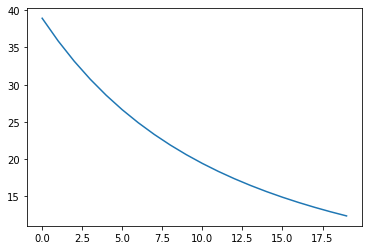

In [13]:
# TensorFlow 1.x - a more complex example
# step 3bis - add dummy graph node that depends on updates
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as pl

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))
w1 = tf.Variable(tf.random_normal((D, n_classes)))

y_pred = tf.maximum(tf.matmul(x, w1), 0.0) # ReLU on logit
diff = y_pred - y
loss = tf.reduce_mean(tf.pow(diff, 2))
grad_w1 = tf.gradients(loss, [w1])[0] # returns a list of
                                      # sums of gradients

alpha = 1e-2
new_w1 = w1.assign(w1 - alpha * grad_w1)
updates = tf.group(new_w1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = { x: x_train, y: y_train}
    J = []
    for epoch in range(20):
        loss_val = sess.run([loss, updates], feed_dict=values)
        J.append(loss_val)
        print("epoch", epoch, loss_val)
    pl.plot(J)

epoch 0 [46.827213, None]
epoch 1 [42.644684, None]
epoch 2 [38.9782, None]
epoch 3 [35.75491, None]
epoch 4 [32.912727, None]
epoch 5 [30.39866, None]
epoch 6 [28.167696, None]
epoch 7 [26.181576, None]
epoch 8 [24.407587, None]
epoch 9 [22.818008, None]
epoch 10 [21.389126, None]
epoch 11 [20.100586, None]
epoch 12 [18.935083, None]
epoch 13 [17.877697, None]
epoch 14 [16.915556, None]
epoch 15 [16.0376, None]
epoch 16 [15.234237, None]
epoch 17 [14.497193, None]
epoch 18 [13.81928, None]
epoch 19 [13.194253, None]


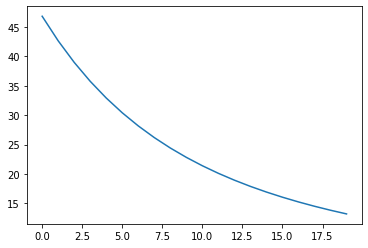

In [14]:
# TensorFlow 1.x - a more complex example
# step 4 - use optimizer and pre-defined loss
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as pl

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))
w1 = tf.Variable(tf.random_normal((D, n_classes)))

y_pred = tf.maximum(tf.matmul(x, w1), 0.0) # ReLU on logit
diff = y_pred - y
loss = tf.losses.mean_squared_error(y_pred, y)

optimizer = tf.train.GradientDescentOptimizer(1e-2)
updates = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = { x: x_train, y: y_train}
    J = []
    for epoch in range(20):
        loss_val = sess.run([loss, updates], feed_dict=values)
        J.append(loss_val)
        print("epoch", epoch, loss_val)
    pl.plot(J)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch 0 0.22798836
epoch 1 0.21367018
epoch 2 0.20128179
epoch 3 0.19053829
epoch 4 0.18119773
epoch 5 0.17305447
epoch 6 0.1659353
epoch 7 0.15969522
epoch 8 0.15420502
epoch 9 0.1493576
epoch 10 0.14506434
epoch 11 0.14124972
epoch 12 0.13784666
epoch 13 0.13480034
epoch 14 0.1320666
epoch 15 0.12960504
epoch 16 0.12737972
epoch 17 0.12536213
epoch 18 0.12352443
epoch 19 0.12184829


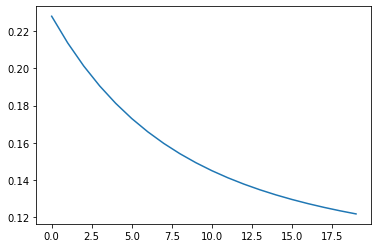

In [15]:
# TensorFlow 1.x - a more complex example
# step 5 - use layers and initilizer
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as pl

x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, n_classes))

init = tf.variance_scaling_initializer(2.0) # He init
y_pred = tf.layers.dense(inputs=x, units=n_classes, 
                         activation=tf.nn.relu, 
                         kernel_initializer=init)

loss = tf.losses.mean_squared_error(y_pred, y)

optimizer = tf.train.GradientDescentOptimizer(1e-2)
updates = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = { x: x_train, y: y_train}
    J = []
    for epoch in range(20):
        loss_val = sess.run([loss, updates], 
                            feed_dict=values)
        J.append(loss_val)
        print("epoch", epoch, loss_val[0])
    pl.plot(J)